# Vanilla RNN - Tensorflow API - Dynamic - Predicting binary sequences

In this notebook we will implement the **same** model of ``"VanillaRNN_Tensorflow.ipynb"`` but using the **Tensorflow RNN Dynamic API**

In the other two notebooks, we added every node for every timestep to the graph before execution. This is called “static” construction. 

We could also let Tensorflow dynamically create the graph at execution time, which can be more efficient. 

To do this, instead of using a list of tensors (of length num_steps and shape  [batch_size, features]), we keep everything in a single 3-dimnesional tensor of shape  [batch_size, num_steps, features], and use Tensorflow’s ``dynamic_rnn`` function. 

<a href="https://r2rt.com/recurrent-neural-networks-in-tensorflow-i.html#using-a-dynamic-rnn">[Ref]</a>

Only four cells are different, they will be distinguished with a separator line like this ▽

---

In [1]:
import numpy as np
import tensorflow as tf
%matplotlib inline
import matplotlib.pyplot as plt

## Hyperparameters

In [2]:
NUM_OBSERVATIONS = 10000

NUM_STEPS = 10 #Number of truncated backprop steps
BATCH_SIZE = 3
NUM_CLASSES = 2 #Binary problem

STATE_SIZE = 16

LEARNING_RATE = 0.1

DISPLAY_FREQ = NUM_OBSERVATIONS//NUM_STEPS//BATCH_SIZE//10

In [3]:
print('With current configuration %d batches per epoch' % (NUM_OBSERVATIONS//NUM_STEPS//BATCH_SIZE))

With current configuration 333 batches per epoch


## Functions

**Gen data:**
- Input sequence (X): At time step t, Xt has a 50% chance of being 1 (and a 50% chance of being 0). E.g., X might be [1, 0, 0, 1, 1, 1 … ].
- Output sequence (Y):At time step t, Yt has a base 50% chance of being 1 (and a 50% base chance to be 0). The chance of Yt being 1 is increased by 50% (i.e., to 100%) if Xt-3 is 1, and decreased by 25% (i.e., to 25%) if Xt-8 is 1. If both Xt-3 and Xt-8 are 1 the chance of Yt being 1 is 50% + 50% - 25%= 75%

In [4]:
def gen_data(size=NUM_OBSERVATIONS):
    X = np.array(np.random.choice(2,size=(size,))) #Random binary array of size 'size'
    Y = [] #Targets
    
    for i in range(size):
        threshold = 0.5
        if X[i-3] == 1: #First dependency at t-3
            threshold += 0.5 
        if X[i-8] == 1:
            threshold -= 0.25
        if np.random.rand() > threshold:
            Y.append(0)
        else:
            Y.append(1)
            
    return X,np.array(Y)

def gen_batch(raw_data,batch_size,num_steps):
    raw_x,raw_y = raw_data
    data_length = len(raw_x)
    
    #Partition data into batches and stack them vertically in a data matrix
    batch_partition_length = data_length//batch_size
    
    data_x = np.zeros(shape=(batch_size,batch_partition_length),dtype=np.int32)
    data_y = np.zeros(shape=(batch_size,batch_partition_length),dtype=np.int32)
    
    for i in range(batch_size):
        data_x[i] = raw_x[batch_partition_length*i : batch_partition_length*(i+1)]
        data_y[i] = raw_y[batch_partition_length*i : batch_partition_length*(i+1)]
        
    #Further divide batch partitions into num_steps for truncated backprop
    epoch_size = batch_partition_length // num_steps
    
    for i in range(epoch_size):
        x = data_x[:,i * num_steps:(i+1) * num_steps]
        y = data_y[:,i * num_steps:(i+1) * num_steps]
        yield(x,y)
        
def gen_epochs(num_epochs,batch_size,num_steps):
    for i in range(num_epochs):
        yield gen_batch(gen_data(),batch_size,num_steps)

## Data

Take a look at how data generating functions works

In [5]:
X,Y = gen_data(10)
X,Y

(array([1, 1, 1, 0, 1, 0, 0, 1, 1, 1]), array([1, 1, 1, 1, 1, 1, 0, 1, 0, 0]))

In [6]:
for x,y in gen_batch([X,Y],batch_size=1,num_steps=NUM_STEPS):
    print('New batch:')
    print(x)
    print(y)

New batch:
[[1 1 1 0 1 0 0 1 1 1]]
[[1 1 1 1 1 1 0 1 0 0]]


## Model

Formally, the model is <a href="https://r2rt.com/recurrent-neural-networks-in-tensorflow-i.html#model_architecture">Click!</a> <- Original post

Diagram of the model:

<a href="https://r2rt.com/recurrent-neural-networks-in-tensorflow-i.html#model_architecture"><img src="https://r2rt.com/static/images/BasicRNNLabeled.png"></a>


## Placeholders

- **x placeholder** will hold our random binary array input
<img src="https://github.com/alberduris/DeepLearning/blob/master/RecurrentNeuralNetworks/R2RT%20-%20RNN%20Tensorflow%20tutorials/src/x_placeholder.png?raw=true">

- **y placeholder** will hold our labels array target
<img src="https://github.com/alberduris/DeepLearning/blob/master/RecurrentNeuralNetworks/R2RT%20-%20RNN%20Tensorflow%20tutorials/src/y_placeholder.png?raw=true">

- **init state placeholder** will hold the state for each batch
<img src="https://github.com/alberduris/DeepLearning/blob/master/RecurrentNeuralNetworks/R2RT%20-%20RNN%20Tensorflow%20tutorials/src/init_state_placeholder.PNG?raw=true">

In [7]:
x = tf.placeholder(shape=[BATCH_SIZE,NUM_STEPS],dtype=tf.int32,name='input_placeholder')
y = tf.placeholder(shape=[BATCH_SIZE,NUM_STEPS],dtype=tf.int32,name='labels_placeholder')
init_state = tf.zeros([BATCH_SIZE,STATE_SIZE],dtype=tf.float32)

In [8]:
x,y,init_state

(<tf.Tensor 'input_placeholder:0' shape=(3, 10) dtype=int32>,
 <tf.Tensor 'labels_placeholder:0' shape=(3, 10) dtype=int32>,
 <tf.Tensor 'zeros:0' shape=(3, 16) dtype=float32>)

---

## RNN Inputs

**rnn_inputs:** OneHot representation of the data

Instead of using a list of tensors (of length num_steps and shape  [batch_size, features]), we keep everything in:

Single3-dimnesional tensor of shape  [batch_size, num_steps, features]

In [9]:
rnn_inputs = tf.one_hot(x,NUM_CLASSES)

In [10]:
rnn_inputs

<tf.Tensor 'one_hot:0' shape=(3, 10, 2) dtype=float32>

---

## Definition of rnn_cell

This is very similar to the ``call`` method on Tensorflow's BasicRNNCell. 
See: https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/rnn/python/ops/rnn_cell.py#L1213

According to their documentation:<br>
Run the cell and add its inputs to its outputs.<br>

It looks like:
<a href="https://r2rt.com/written-memories-understanding-deriving-and-extending-the-lstm.html"><img src="https://r2rt.com/static/images/NH_VanillaRNNcell.png" width="400px"></a>

---

Replace our function for building rnn cells

With TF API for RNN cells → **BasicRNNCell**

In [11]:
cell = tf.contrib.rnn.BasicRNNCell(STATE_SIZE)

---

## Adding rnn_cells to graph

This is a simplified version of the "static_rnn" function from Tensorflow's api.
See: https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/ops/rnn.py#L1092

According to their documentation:<br>
Creates a recurrent neural network specified by RNNCell `cell`.

It looks like:

<a href="https://r2rt.com/written-memories-understanding-deriving-and-extending-the-lstm.html"><img src="https://r2rt.com/static/images/NH_ComposedRNNcells.png"></a>

---

Replace our code for adding the cells to the graph and getting the ``final_state`` and ``rnn_outputs``

With the TF API → **dynamic_rnn**

In [12]:
rnn_outputs, final_state = tf.nn.dynamic_rnn(cell=cell,inputs=rnn_inputs,initial_state=init_state)

And thats all

---

## Predictions, loss, training step

Predictions will be the result of **softmax** to the **logits**. **Logits** will be the result of matrix multiplication with **Wout** and **bout**.

Because of the steps, instead of one, we will have several **losses**, one for each step. **Total loss** will be just the mean of every losses.

As **optimizer** we'll be using the **Adagradoptimizer**, to do de backpropagation, feel free to experiment with that.

---

Because of the dynamic API we no longer need to do our ``for`` loops anymore. 

In [13]:
##Predictions##
with tf.variable_scope('softmax'):
    W = tf.get_variable('W',[STATE_SIZE,NUM_CLASSES])
    b = tf.get_variable('b',[NUM_CLASSES],initializer=tf.constant_initializer(0.0))
    
#Reshape needed
logits = tf.reshape(tf.matmul(tf.reshape(rnn_outputs,shape=[-1,STATE_SIZE]),W) + b,shape=[BATCH_SIZE,NUM_STEPS,NUM_CLASSES])
predictions = tf.nn.softmax(logits)



##Losses##
losses = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,logits=logits)
total_loss = tf.reduce_mean(losses)

##Optimizer##
train_step = tf.train.AdagradOptimizer(LEARNING_RATE).minimize(total_loss)

--- 

## Train

In [14]:
def train_network(num_epochs):
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        training_losses = []
        
        for idx,epoch in enumerate(gen_epochs(num_epochs,BATCH_SIZE,NUM_STEPS)):
            training_loss = 0
            training_state = np.random.normal(size=(BATCH_SIZE,STATE_SIZE)) #Random initiate state
        
            print('Epoch %d'%idx)
            
            for step,(X,Y) in enumerate(epoch):
                
                feed_dict = {x:X,y:Y,init_state:training_state}
                tr_losses,training_loss_,training_state,_ = sess.run([losses,total_loss,final_state,train_step],feed_dict)
                training_loss += training_loss_
                
                if(step % 100 == 0 and step > 0):
                    print('Average loss at step %d for last 250 steps: %.3f'%(step,training_loss/100))
                    training_losses.append(training_loss/100)
                    training_loss = 0
                
    return training_losses

In [15]:
training_losses = train_network(num_epochs=10)

Epoch 0
Average loss at step 100 for last 250 steps: 0.549
Average loss at step 200 for last 250 steps: 0.497
Average loss at step 300 for last 250 steps: 0.486
Epoch 1
Average loss at step 100 for last 250 steps: 0.512
Average loss at step 200 for last 250 steps: 0.490
Average loss at step 300 for last 250 steps: 0.476
Epoch 2
Average loss at step 100 for last 250 steps: 0.486
Average loss at step 200 for last 250 steps: 0.493
Average loss at step 300 for last 250 steps: 0.493
Epoch 3
Average loss at step 100 for last 250 steps: 0.484
Average loss at step 200 for last 250 steps: 0.485
Average loss at step 300 for last 250 steps: 0.489
Epoch 4
Average loss at step 100 for last 250 steps: 0.488
Average loss at step 200 for last 250 steps: 0.485
Average loss at step 300 for last 250 steps: 0.481
Epoch 5
Average loss at step 100 for last 250 steps: 0.477
Average loss at step 200 for last 250 steps: 0.468
Average loss at step 300 for last 250 steps: 0.475
Epoch 6
Average loss at step 100 f

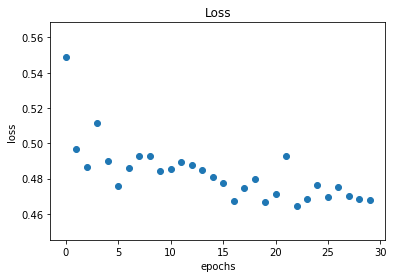

In [16]:
plt.title('Loss')
plt.scatter(x=np.arange(0,len(training_losses)),y=training_losses)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show();